In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [7]:
!pip install hurst
from hurst import compute_Hc

In [13]:
prices = pd.read_csv('finaldata.csv', parse_dates=['Timestamp'], index_col='Timestamp')

prices = prices.apply(lambda col: col.abs() if col.name != 'Timestamp' else col)



In [14]:
# calculate cumulative returns
cumret = np.log(prices).diff().cumsum()+1
cumret.dropna(how='all', inplace=True)
cumret.dropna(axis=1, inplace=True)

In [15]:
# define a set of formation\trading periods
periods = [('2016-07-01', '2017-07-01', '2017-07-01', '2018-01-01'),
           ('2016-08-01', '2017-08-01', '2017-08-01', '2018-02-01'),
           ('2016-09-01', '2017-09-01', '2017-09-01', '2018-03-01'),
           ('2016-10-01', '2017-10-01', '2017-10-01', '2018-04-01'),
           ('2016-11-01', '2017-11-01', '2017-11-01', '2018-05-01'),
           ('2016-12-01', '2017-12-01', '2017-12-01', '2018-06-01'),
           ('2017-01-01', '2018-01-01', '2018-01-01', '2018-07-01'),
           ('2017-02-01', '2018-02-01', '2018-02-01', '2018-08-01'),
           ('2017-03-01', '2018-03-01', '2018-03-01', '2018-09-01'),
           ('2017-04-01', '2018-04-01', '2018-04-01', '2018-10-01'),
           ('2017-05-01', '2018-05-01', '2018-05-01', '2018-11-01'),
           ('2017-06-01', '2018-06-01', '2018-06-01', '2018-12-01'),
           ('2017-07-01', '2018-07-01', '2018-07-01', '2019-01-01'),
           ('2017-08-01', '2018-08-01', '2018-08-01', '2019-02-01'),
           ('2017-09-01', '2018-09-01', '2018-09-01', '2019-03-01'),
           ('2017-10-01', '2018-10-01', '2018-10-01', '2019-04-01'),
           ('2017-11-01', '2018-11-01', '2018-11-01', '2019-05-01'),
           ('2017-12-01', '2018-12-01', '2018-12-01', '2019-06-01'),
           ('2018-01-01', '2019-01-01', '2019-01-01', '2019-07-01'),
           ('2018-02-01', '2019-02-01', '2019-02-01', '2019-08-01'),
           ('2018-03-01', '2019-03-01', '2019-03-01', '2019-09-01'),
           ('2018-04-01', '2019-04-01', '2019-04-01', '2019-10-01'),
           ('2018-05-01', '2019-05-01', '2019-05-01', '2019-11-01'),
           ('2018-06-01', '2019-06-01', '2019-06-01', '2019-12-01'),
           ('2018-07-01', '2019-07-01', '2019-07-01', '2020-01-01')]

In [19]:
def parse_pair(pair):
    '''
    parse pair string S1-S2
    return tickers S1, S2
    '''
    dp = pair.find('-')
    s1 = pair[:dp]
    s2 = pair[dp+1:]

    return s1,s2

def cadf_pvalue(s1, s2, cumret):
    '''
    perform CADF cointegration tests
    since it is sensitive to the order of stocks in the pair, perform both tests (s1-2 and s2-s1)
    return the smallest p-value of two tests
    '''
    from statsmodels.tsa.stattools import coint

    p1 = coint(cumret[s1], cumret[s2])[1]
    p2 = coint(cumret[s2], cumret[s1])[1]

    return min(p1,p2)

def calculate_halflife(spread):
    '''
    calculate half-life of mean reversion of the spread
    '''
    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant

    ylag = spread.shift()
    deltay = spread - ylag
    ylag.dropna(inplace=True)
    deltay.dropna(inplace=True)

    res = OLS(deltay, add_constant(ylag)).fit()
    halflife = -np.log(2)/res.params[0]

    return halflife

def calculate_metrics(pairs, cumret, pairs_df):
    '''
    calculate metrics for pairs using data in cumret
    return dataframe of results
    '''
    from hurst import compute_Hc
    from statsmodels.tsa.stattools import adfuller
    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant
    from statsmodels.tsa.stattools import coint

    cols = ['Distance', 'CADF p-value', 'ADF p-value', 'Spread SD', 'Pearson r',
        'Num zero-crossings', 'Hurst Exponent', 'Half-life of mean reversion', '% days within historical 2-SD band']
    results = pd.DataFrame(index=pairs, columns=cols)

    for pair in pairs:
        s1,s2 = parse_pair(pair)
        hedge_ratio = pairs_df.loc[pair]['Hedge ratio']
        spread = cumret[s1] - hedge_ratio*cumret[s2]
        results.loc[pair]['CADF p-value'] = coint(cumret[s1], cumret[s2])[1]
        results.loc[pair]['ADF p-value'] = adfuller(spread)[1]
        hist_mu = pairs_df.loc[pair]['Spread mean'] # historical mean
        hist_sd = pairs_df.loc[pair]['Spread SD'] # historical standard deviation
        results.loc[pair]['Spread SD'] = hist_sd
        results.loc[pair]['Pearson r'] = np.corrcoef(cumret[s1], cumret[s2])[0][1]
        # subtract the mean to calculate distances and num_crossings
        spread_nm = spread - hist_mu
        results.loc[pair]['Distance'] = np.sqrt(np.sum((spread_nm)**2))
        results.loc[pair]['Num zero-crossings'] = ((spread_nm[1:].values * spread_nm[:-1].values) < 0).sum()
        results.loc[pair]['Hurst Exponent'] = compute_Hc(spread)[0]
        results.loc[pair]['Half-life of mean reversion'] = calculate_halflife(spread)
        results.loc[pair]['% days within historical 2-SD band'] = (abs(spread-hist_mu) < 2*hist_sd).sum() / len(spread) * 100

    return results

def plot_pairs(pairs, cumret_train, cumret_test):
    '''
    plot cumulative returns of the spread for each pair in pairs
    '''

    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant

    for pair in pairs:
        s1,s2 = parse_pair(pair)
        res = OLS(cumret_train[s1], add_constant(cumret_train[s2])).fit()
        spread_train = cumret_train[s1] - res.params[s2]*cumret_train[s2]
        spread_test = cumret_test[s1] - res.params[s2]*cumret_test[s2]
        spread_mean = spread_train.mean() # historical mean
        spread_std = spread_train.std() # historical standard deviation

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,4))
        fig.suptitle(f'Spread of {pair} pair', fontsize=16)
        ax1.plot(spread_train, label='spread')
        ax1.set_title('Formation period')
        ax1.axhline(y=spread_mean, color='g', linestyle='dotted', label='mean')
        ax1.axhline(y=spread_mean+2*spread_std, color='r', linestyle='dotted', label='2-SD band')
        ax1.axhline(y=spread_mean-2*spread_std, color='r', linestyle='dotted')
        ax1.legend()
        ax2.plot(spread_test, label='spread')
        ax2.set_title('Trading period')
        ax2.axhline(y=spread_mean, color='g', linestyle='dotted', label='mean')
        ax2.axhline(y=spread_mean+2*spread_std, color='r', linestyle='dotted', label='2-SD band')
        ax2.axhline(y=spread_mean-2*spread_std, color='r', linestyle='dotted')
        ax2.legend()

def select_pairs(train):
    '''
    select pairs using data from train dataframe
    return dataframe of selected pairs
    '''
    tested = []

    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant
    from hurst import compute_Hc
    from statsmodels.tsa.stattools import adfuller
    from statsmodels.tsa.stattools import coint

    cols = ['Distance', 'Num zero-crossings', 'Pearson r', 'Spread mean',
            'Spread SD', 'Hurst Exponent', 'Half-life of mean reversion', 'Hedge ratio']
    pairs = pd.DataFrame(columns=cols)

    for s1 in train.columns:
        for s2 in train.columns:
            if s1!=s2 and (f'{s1}-{s2}' not in tested):
                tested.append(f'{s1}-{s2}')
                cadf_p = coint(train[s1], train[s2])[1]
                if cadf_p<0.01 and (f'{s2}-{s1}' not in pairs.index): # stop if pair already added as s2-s1
                    res = OLS(train[s1], add_constant(train[s2])).fit()
                    hedge_ratio = res.params[s2]
                    if hedge_ratio > 0: # hedge ratio should be posititve
                        spread = train[s1] - hedge_ratio*train[s2]
                        hurst = compute_Hc(spread)[0]
                        if hurst<0.5:
                            halflife = calculate_halflife(spread)
                            if halflife>1 and halflife<30:
                                # subtract the mean to calculate distances and num_crossings
                                spread_nm = spread - spread.mean()
                                num_crossings = (spread_nm.values[1:] * spread_nm.values[:-1] < 0).sum()
                                if num_crossings>len(train.index)/252*12:
                                    distance = np.sqrt(np.sum(spread_nm**2))
                                    pearson_r = np.corrcoef(train[s1], train[s2])[0][1]
                                    pairs.loc[f'{s1}-{s2}'] = [distance, num_crossings, pearson_r, spread.mean(),
                                                               spread.std(), hurst, halflife, hedge_ratio]

    return pairs

In [21]:
cumret48_36 = cumret.loc['2016-03-15':]
cumret48_36 = cumret48_36 / cumret48_36.iloc[0] # divide by first row so that all prices start at 1
train48_36 = cumret48_36.loc['2016-03-15':'2020-01-24'] # formation period
test48_36 = cumret48_36.loc['2020-01-25':'2022-12-06'] # trading period
data = select_pairs(train48_36)
data

,Distance,Num zero-crossings,Pearson r,Spread mean,Spread SD,Hurst Exponent,Half-life of mean reversion,Hedge ratio
Instr1-Instr2,10.166989,75.0,0.950250,-0.032222,0.321992,0.395199,1.233077,0.973676
Instr1-Instr3,12.221508,63.0,0.927254,-0.050791,0.387059,0.346086,1.171195,0.962287
Instr1-Instr4,14.010682,57.0,0.903187,-0.070576,0.443723,0.383944,1.224167,0.943260
Instr1-Instr5,14.370313,61.0,0.897867,-0.083345,0.455112,0.363294,1.442825,0.976230
Instr1-Instr6,16.467523,57.0,0.863401,-0.106343,0.521532,0.379346,1.414543,0.924971
...,...,...,...,...,...,...,...,...
Instr16-Instr2,17.316054,70.0,0.762564,0.076508,0.548405,0.329259,2.649692,0.640775
Instr16-Instr3,16.408135,62.0,0.790088,0.075309,0.519651,0.298652,2.260479,0.672410
Instr17-Instr1,19.430723,72.0,0.704031,0.074612,0.615377,0.315234,2.421441,0.590158
Instr17-Instr2,18.520889,68.0,0.736061,0.072727,0.586562,0.320132,2.416904,0.632218


In [22]:
data = data[(data['Hedge ratio']<3) & (data['Hedge ratio'] > 0.33)]
data.dtypes

Distance                       float64
Num zero-crossings             float64
Pearson r                      float64
Spread mean                    float64
Spread SD                      float64
Hurst Exponent                 float64
Half-life of mean reversion    float64
Hedge ratio                    float64
dtype: object

In [23]:
data.describe()


,Distance,Num zero-crossings,Pearson r,Spread mean,Spread SD,Hurst Exponent,Half-life of mean reversion,Hedge ratio
count,69.000000,69.00000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,13.763014,61.73913,0.872600,-0.037835,0.435879,0.337380,1.477365,0.880286
std,3.223966,11.71431,0.061172,0.082233,0.102104,0.027172,0.384404,0.129253
min,5.990257,49.00000,0.704031,-0.164200,0.189713,0.281489,1.009428,0.590158
25%,11.360647,51.00000,0.834303,-0.109112,0.359795,0.321582,1.171195,0.815753
50%,14.039124,57.00000,0.881815,-0.050791,0.444624,0.334059,1.387564,0.924971
75%,16.272322,72.00000,0.918512,0.055036,0.515350,0.348786,1.644063,0.965834
max,19.729419,88.00000,0.973940,0.078857,0.624837,0.420578,2.649692,1.057020


In [24]:
data.corr()


,Distance,Num zero-crossings,Pearson r,Spread mean,Spread SD,Hurst Exponent,Half-life of mean reversion,Hedge ratio
Distance,1.000000,-0.129092,-0.904965,-0.240111,1.000000,-0.342583,0.725178,-0.282236
Num zero-crossings,-0.129092,1.000000,-0.129701,0.841142,-0.129092,-0.083073,0.151252,-0.721265
Pearson r,-0.904965,-0.129701,1.000000,-0.126909,-0.904965,0.431532,-0.882996,0.618375
Spread mean,-0.240111,0.841142,-0.126909,1.000000,-0.240111,-0.031706,0.242065,-0.833670
Spread SD,1.000000,-0.129092,-0.904965,-0.240111,1.000000,-0.342583,0.725178,-0.282236
Hurst Exponent,-0.342583,-0.083073,0.431532,-0.031706,-0.342583,1.000000,-0.352898,0.236656
Half-life of mean reversion,0.725178,0.151252,-0.882996,0.242065,0.725178,-0.352898,1.000000,-0.644461
Hedge ratio,-0.282236,-0.721265,0.618375,-0.833670,-0.282236,0.236656,-0.644461,1.000000


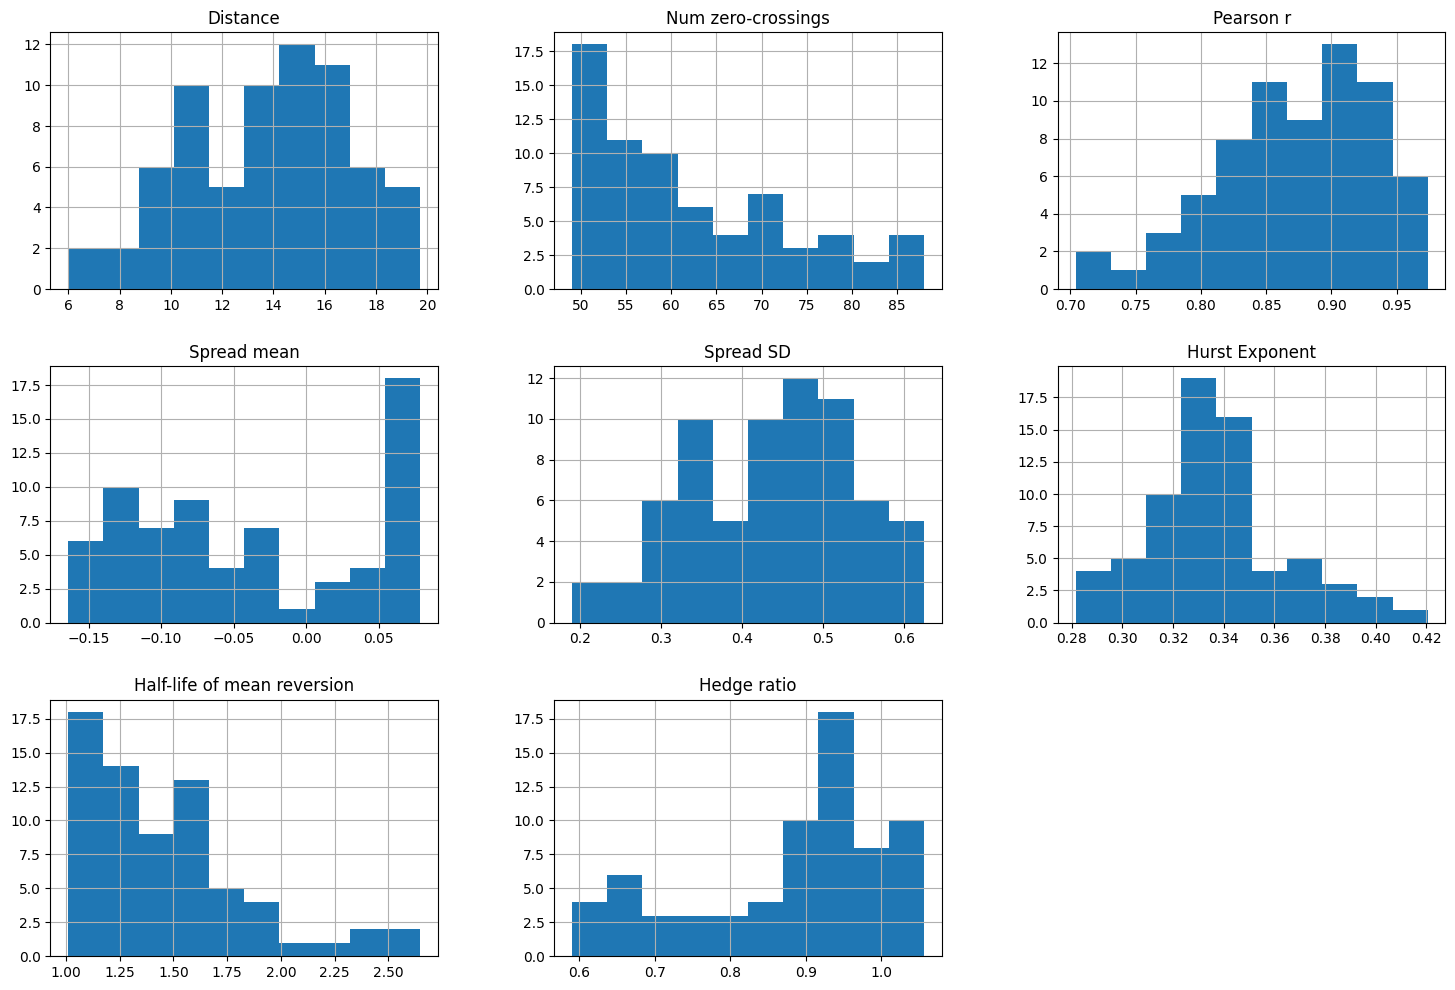

In [25]:
_ = data.hist(figsize=(18,12))


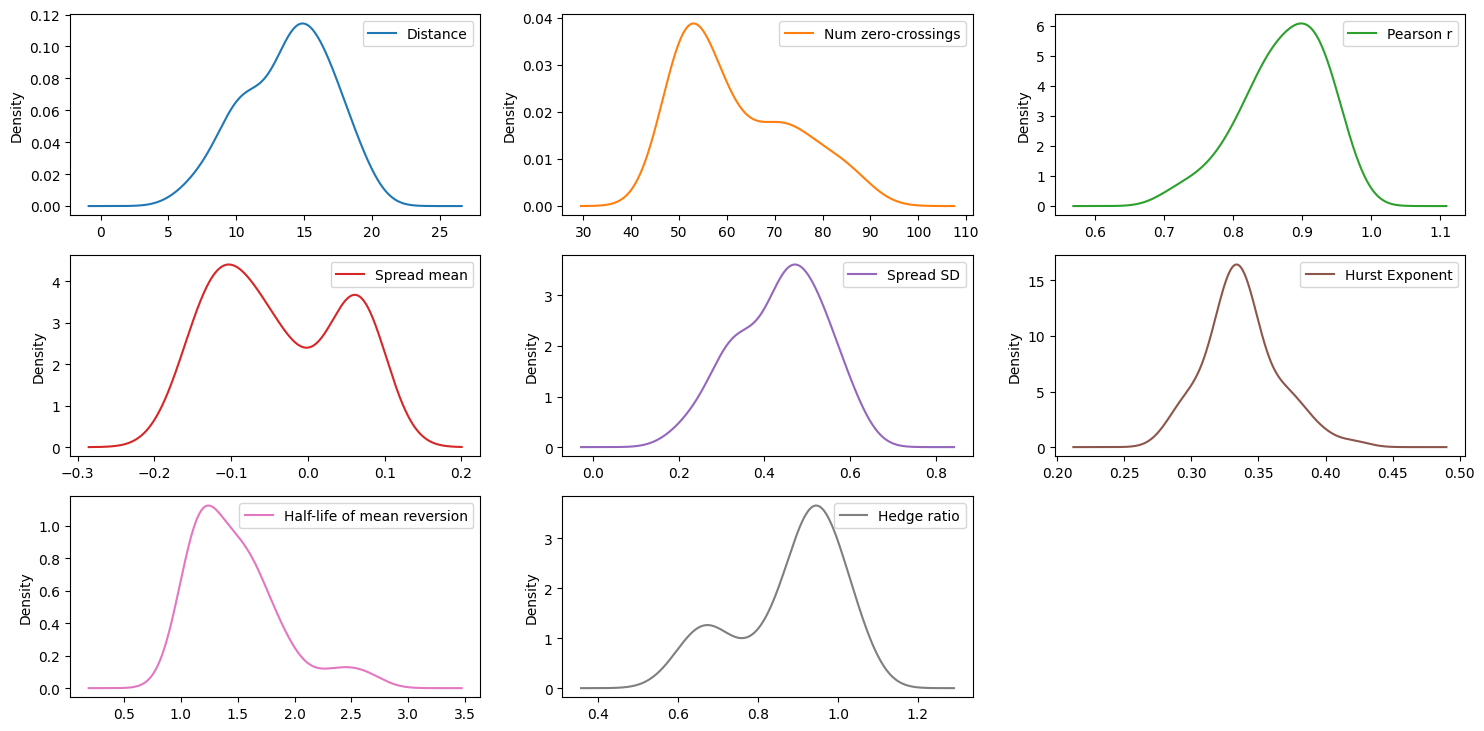

In [26]:
_ = data.plot(kind='density', subplots=True, layout=(4,3), sharex=False, figsize=(18,12))


In [27]:
len(data.columns)


8

In [28]:
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [31]:
X = data.values[:,:7]
y = data.values[:,7]
binarizer = Binarizer(threshold=30).fit(y.reshape(-1,1))
y_bin = binarizer.transform(y.reshape(-1,1)).flatten()
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.3, shuffle=True,
                                                    random_state=14, stratify=y_bin)


In [32]:
# benchmark score
len(y_train[y_train==0]) / len(y_train)

1.0

In [33]:
def top10_accuracy(estimator, X, y):
    '''
    compute accuracy of top 10 predictions:
    select top 10 samples with the highest probability of belonging to class 0
    return the fraction of samples actually belonging to class 0
    '''
    pred_prob = estimator.predict_proba(X)[:,0]
    top10_ind = np.argsort(pred_prob)[-10:]
    top10_prob = pred_prob[top10_ind]
    # if at least one of top ten probabilities is less than 0.5, return 0 score
    if len(top10_prob[top10_prob<0.5])>0:
        score = 0
    else:
        score = sum(y[top10_ind] == np.zeros(10))/10

    return score

In [34]:
def test_models_class(models, X=X_train, y=y_train, n_folds=10, scoring=top10_accuracy, seed=45):
    '''
    cross-validate each model in models using n_folds and scoring
    '''

    results = []
    names = []
    for name,model in models:
        kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        print(f'{name}: {cv_results.mean()} ({cv_results.std()})')

    return results, names

In [35]:
models = []
models.append(('LR', LogisticRegressionCV(max_iter=1000, class_weight='balanced', scoring=top10_accuracy)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('QDA_1', QuadraticDiscriminantAnalysis()))
models.append(('QDA_2', QuadraticDiscriminantAnalysis(reg_param=0.1)))
models.append(('KNN_1', KNeighborsClassifier()))
models.append(('KNN_2', KNeighborsClassifier(weights='distance')))
models.append(('CART_1', DecisionTreeClassifier(class_weight='balanced')))
models.append(('CART_2', DecisionTreeClassifier(max_features='auto', class_weight='balanced')))
models.append(('NB', GaussianNB()))
models.append(('GPC', GaussianProcessClassifier(1.0 * RBF(1.0), n_jobs=-1)))
models.append(('MLP_1', MLPClassifier(max_iter=5000)))
models.append(('MLP_2', MLPClassifier(alpha=1, max_iter=5000)))
models.append(('SVM', SVC(class_weight='balanced', probability=True)))

results,names = test_models_class(models)

ValueError: ignored

In [36]:
pipelines = []
for name,model in models:
    pipelines.append((f'scaled{name}', Pipeline([('scaler', PowerTransformer()),
                                                 (name,model)])))

results,names = test_models_class(pipelines)

ValueError: ignored